# Full Pipeline:


1.   Data Cleaning: Scrapped Review + Sentiment Analysis new Column
2.   Data Cleaning: Passenger Booking

1.   Data Engineering using both files
2.   Predictive Model

1.   Inference Function
2.   SHAP and LIME Explanations (global and local)










In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import calendar
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
%pip install shap lime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [29]:
df = pd.read_csv("/content/AirlineScrappedReview_Cleaned.csv")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

In [25]:
df.describe()

,Rating,Start_Latitude,Start_Longitude,End_Latitude,End_Longitude,Sentiment_Score
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,4.758755,42.393073,-2.409793,40.360276,-1.593776,0.061790
std,3.176898,17.307218,45.362551,18.913213,46.725766,0.223856
min,1.000000,-37.666951,-123.182909,-37.814245,-123.179234,-0.676300
25%,2.000000,41.875562,-0.458780,38.895037,-0.458780,-0.097000
50%,4.000000,46.314475,-0.127765,46.314475,-0.127765,0.038250
75%,8.000000,51.467739,11.048029,51.467739,11.048029,0.207300
max,10.000000,65.011873,151.208285,64.145981,174.550610,0.919500


In [ ]:
df.isna().sum()

Check if there is missing Review Content before Feature Engineering.

Since no missing we can go ahead and feature engineer Review Content even if it is before rest of attributes cleaning as we only need review content attribute.

In [5]:
# Check for missing values in Review_content
print("Missing values in Review_content column:")
print(df['Review_content'].isnull().sum())

Missing values in Review_content column:
0


This code performs sentiment analysis on airline customer reviews to understand passengers’ overall emotions and opinions. It calculates a sentiment score for each review using VADER and categorizes them as positive, neutral, or negative. The results are then visualized in a bar chart showing how reviews are distributed across these categories. This analysis helps identify the general satisfaction level of travelers and sets the stage for deeper insights, such as exploring what factors contribute most to negative or positive experiences.

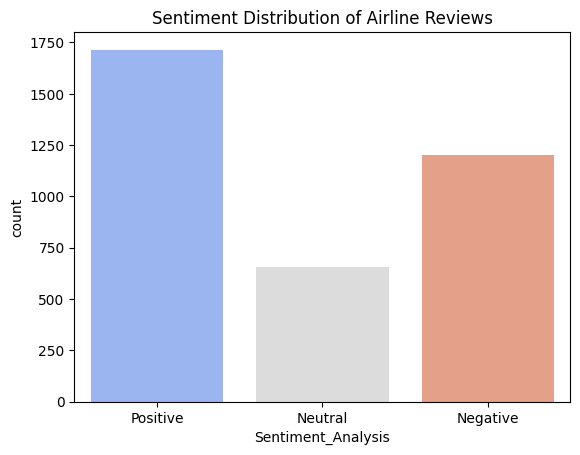

In [6]:
sia = SentimentIntensityAnalyzer()

def sentence_level_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    sentences = sent_tokenize(text)
    scores = [sia.polarity_scores(s)['compound'] for s in sentences]
    return sum(scores) / len(scores)

df['Sentiment_Score'] = df['Review_content'].apply(sentence_level_sentiment)

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Analysis'] = df['Sentiment_Score'].apply(label_sentiment)

sns.countplot(x='Sentiment_Analysis', data=df, order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')
plt.title('Sentiment Distribution of Airline Reviews')
plt.show()

In [7]:

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np


geolocator = Nominatim(user_agent="airline_data_cleaning")
# Increased min_delay_seconds but removed timeout from RateLimiter
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=5)

def get_location(lat, lon):
    try:
        if pd.notna(lat) and pd.notna(lon):
            # Pass timeout to the reverse call
            location = reverse((lat, lon), language='en', timeout=10)
            if location and location.address:
                addr = location.raw.get('address', {})
                city = addr.get('city') or addr.get('town') or addr.get('village') or addr.get('state')
                resolved_location = city if city else location.address
                print(f"✅ Successfully retrieved location for ({lat}, {lon}): {resolved_location}") # Print success message
                return resolved_location
    except Exception as e: # Catch specific exceptions or broader Exception to see the error
        print(f"Error getting location for ({lat}, {lon}): {e}")
        return np.nan
    return np.nan

# Fill missing Start_Location
mask_start = df['Start_Location'].isna() & df['Start_Latitude'].notna() & df['Start_Longitude'].notna()
df.loc[mask_start, 'Start_Location'] = df.loc[mask_start].apply(
    lambda row: get_location(row['Start_Latitude'], row['Start_Longitude']), axis=1
)

# Fill missing End_Location
mask_end = df['End_Location'].isna() & df['End_Latitude'].notna() & df['End_Longitude'].notna()
df.loc[mask_end, 'End_Location'] = df.loc[mask_end].apply(
    lambda row: get_location(row['End_Latitude'], row['End_Longitude']), axis=1
)

print("✅ Missing Start and End locations filled (where coordinates available).")

✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (46.3144754, 11.0480288): Ville d'Anaunia
✅ Successfully retrieved location for (4

This script automatically fills missing latitude and longitude values for both Start_Location and End_Location in the airline reviews dataset.

🔍 How It Works

Cleans location names using the clean_location_name() function — removing unnecessary words like "airport", punctuation, and extra spaces.

Uses the Nominatim API (via geopy) to geocode cleaned location names and retrieve accurate latitude and longitude values.

Iterates through missing entries in both start and end coordinates:

If valid coordinates are found, they are added to the dataset.

If not, a warning is printed.

Reports progress and summary of remaining missing values.

✅ This step ensures complete and consistent geolocation data for all routes, improving accuracy for mapping and spatial visualizations.

In [26]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import re
import numpy as np
import pandas as pd

geolocator = Nominatim(user_agent="airline_location_filler")
# Increased min_delay_seconds and set error_wait_seconds
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=10, error_wait_seconds=10) # Set error_wait_seconds

def clean_location_name(name):
    if not isinstance(name, str):
        return np.nan
    name = name.lower()
    name = re.sub(r'\([^)]*\)', '', name)  # remove text in parentheses
    name = re.sub(r'\b(international|airport|airpt|airlines?|terminal|int|intl)\b', '', name)
    name = re.sub(r'[-,]', ' ', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().title()

def get_lat_lon(location):
    try:
        # Pass timeout to the geocode call
        loc = geocode(location, timeout=30) # Increased timeout to 30 seconds
        if loc:
            return loc.latitude, loc.longitude
    except Exception as e: # Catch specific exceptions or broader Exception to see the error
        print(f"Error getting coordinates for {location}: {e}")
        return np.nan, np.nan
    return np.nan, np.nan

# ---------- Fill missing START coordinates ----------
missing_start = df[df['Start_Latitude'].isna() | df['Start_Longitude'].isna()]

for idx, row in missing_start.iterrows():
    cleaned = clean_location_name(row['Start_Location'])
    if isinstance(cleaned, str) and cleaned != "":
        lat, lon = get_lat_lon(cleaned)
        if pd.notna(lat) and pd.notna(lon):
            df.at[idx, 'Start_Latitude'] = lat
            df.at[idx, 'Start_Longitude'] = lon
            print(f"✅ Start filled: {row['Start_Location']} → ({lat:.4f}, {lon:.4f})")
        else:
            print(f"⚠️ Start not found: {row['Start_Location']}")

# ---------- Fill missing END coordinates ----------
missing_end = df[df['End_Latitude'].isna() | df['End_Longitude'].isna()]

for idx, row in missing_end.iterrows():
    cleaned = clean_location_name(row['End_Location'])
    if isinstance(cleaned, str) and cleaned != "":
        lat, lon = get_lat_lon(cleaned)
        if pd.notna(lat) and pd.notna(lon):
            df.at[idx, 'End_Latitude'] = lat
            df.at[idx, 'End_Longitude'] = lon
            print(f"✅ End filled: {row['End_Location']} → ({lat:.4f}, {lon:.4f})")
        else:
            print(f"⚠️ End not found: {row['End_Location']}")

print("\n✅ All missing Start and End coordinates processed.")
print("Remaining missing values:")
print("Start_Latitude:", df['Start_Latitude'].isna().sum())
print("End_Latitude:", df['End_Latitude'].isna().sum())


✅ All missing Start and End coordinates processed.
Remaining missing values:
Start_Latitude: 0
End_Latitude: 0


This script cleans and standardizes location names and fills in missing route information for the airline dataset.

⚙️ Step-by-Step Summary

clean_location_name() function:

Converts names to lowercase.

Removes unnecessary words like “airport”, “international”, etc.

Removes text inside parentheses and extra punctuation/spaces.

Returns a clean, properly capitalized location name.

Cleans both location columns:

Applies the cleaning function to Start_Location and End_Location.

Fills missing routes:

For any missing Route, constructs it as "Start_Location to End_Location".

✅ This ensures all routes are consistently formatted and complete, making the dataset ready for visualization and analysis.

In [9]:
import pandas as pd
import numpy as np
import re

def clean_location_name(name):
    if not isinstance(name, str):
        return np.nan
    name = name.lower()
    name = re.sub(r'\([^)]*\)', '', name)  # remove text in parentheses
    name = re.sub(r'\b(international|airport|airpt|airlines?|terminal|int|intl)\b', '', name)
    name = re.sub(r'[-,]', ' ', name)
    name = re.sub(r'\s+', ' ', name)
    return name.strip().title()

# --- Clean Start and End locations ---
df['Start_Location'] = df['Start_Location'].apply(clean_location_name)
df['End_Location'] = df['End_Location'].apply(clean_location_name)

# --- Fill missing Route values ---
missing_routes = df['Route'].isna()
df.loc[missing_routes, 'Route'] = df.loc[missing_routes].apply(
    lambda row: f"{row['Start_Location']} to {row['End_Location']}"
    if pd.notna(row['Start_Location']) and pd.notna(row['End_Location'])
    else np.nan,
    axis=1
)





We removed Layover_Route because it was:

🧩 Redundant — the main Route column (constructed as Start → End) already represents the flight path. The layover doesn’t add unique analytical value for most visualizations or sentiment insights.

📉 Incomplete — only a small fraction of entries (484 out of 3575) had Layover_Route filled, making it too sparse to be useful for modeling or aggregation.

🧼 Simplifies the dataset — removing it makes the data cleaner and more consistent, focusing on core fields (Start_Location, End_Location, and Route) that are now complete and standardized.

In short: it was mostly empty, repetitive, and unnecessary for your current analysis goals.

In [10]:
df = df.drop(columns=['Layover_Route'])
df = df.drop(columns=['Flying_Date'])
df = df.dropna()

Perfect — that line saves your fully cleaned and standardized dataset to a CSV file named cleaned_airline_reviews.csv in your working directory.

Here’s what it does:

index=False → prevents pandas from adding row numbers as an extra column.

encoding='utf-8-sig' → ensures correct encoding (especially for non-English text like Arabic city names).

to_csv() → writes the DataFrame to a CSV file that you can easily open in Excel, Power BI, or reload later for further analysis.

In short:

💾 You’ve successfully exported your final cleaned dataset — ready for analysis, visualization, or machine learning.

Check Duplicates and Remove if found

In [15]:
df.duplicated().sum()

np.int64(74)

In [16]:
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"Removed {initial_rows - len(df)} duplicate rows.")

Removed 74 duplicate rows.


In [17]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.isna().sum()

,0
Passanger_Name,0
Route,0
Rating,0
Verified,0
Review_title,0
Review_content,0
Traveller_Type,0
Class,0
Start_Location,0
End_Location,0


In [28]:
df.shape

(3341, 18)

In [31]:
df.to_csv("cleaned_airline_reviews.csv", index=False, encoding='utf-8-sig')

# 📘 Data Loading and Initial Exploration

This section of the code focuses on loading the dataset, performing a quick inspection, and understanding the structure of the data before any preprocessing or modeling steps.  
Each choice made below ensures the analyst gains an immediate overview of the dataset’s composition and quality.

---

### **Code & Explanation**

```python
import pandas as pd
# Choice: Import the pandas library.
```
Justification: pandas is the most widely used library for data manipulation and analysis in Python.
It provides high-performance data structures like the DataFrame, which allows for easy reading,
filtering, summarizing, and cleaning of tabular datasets.
```python
df = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
```
Choice: Read the dataset from a CSV file using pd.read_csv().
Justification: read_csv is the most common and efficient way to load structured data into a pandas DataFrame.
The path /kaggle/input/... indicates this notebook is being run on Kaggle,
where datasets are stored in a standardized input directory.
By storing it in df, we create a DataFrame object that will hold all rows and columns
of our dataset for further analysis.
```python

print("First 5 rows of the dataset:")
print(df.head())
```
Choice: Display the first 5 rows using df.head().
Justification: This is an essential first step in any data exploration workflow.
df.head() quickly previews the top rows, helping verify that the dataset loaded correctly,
that column names are as expected, and that there are no obvious formatting or encoding issues.
It gives an immediate sense of what types of values each feature contains.

```python

print("\nDataset Information:")
df.info()
```
Choice: Call df.info() to display metadata about the dataset.
Justification: info() provides details such as the number of rows, column names,
data types, and non-null counts. This is critical for identifying missing values,
understanding data volume, and checking whether each column has the appropriate data type
(e.g., integers for counts, floats for continuous values, or objects for categorical data).
The preceding print ensures clean formatting in the console output.

```python

print("\nDescriptive Statistics:")
print(df.describe())
```
Choice: Use df.describe() to generate descriptive statistics.
Justification: This method summarizes numerical columns by providing metrics like mean,
standard deviation, min, max, and quartile values. These insights help identify outliers,
scaling issues, and general trends in the data distribution.
Including the print statement ensures that this output appears clearly separated from previous sections
when displayed.


In [44]:
import pandas as pd

df_passernger = pd.read_csv('/content/Passanger_booking_data.csv')


print("Unique values in 'flight_day':")
print(df['flight_day'].unique())
print(f"Count: {df['flight_day'].nunique()} unique days")

print("\nUnique values in 'sales_channel':")
print(df['sales_channel'].unique())

print("\nUnique values in 'trip_type':")
print(df['trip_type'].unique())

print("\nTop 10 booking origins:")
print(df['booking_origin'].value_counts().head(10))

Unique values in 'flight_day':
['Tue' 'Sat' 'Wed' 'Thu' 'Mon' 'Sun' 'Fri']
Count: 7 unique days

Unique values in 'sales_channel':
['Internet' 'Mobile']

Unique values in 'trip_type':
['RoundTrip' 'CircleTrip' 'OneWay']

Top 10 booking origins:
booking_origin
Australia      17873
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Indonesia       2369
Taiwan          2077
Thailand        2030
India           1270
New Zealand     1074
Name: count, dtype: int64


# ✈️ Exploring Categorical Features and Unique Values

This section focuses on exploring categorical columns within the dataset to understand the distinct categories, frequency distributions, and general patterns present.  
Inspecting unique values early helps identify inconsistencies, data encoding issues, and provides insight into potential feature engineering opportunities.

---

### **Code & Explanation**

```python
import pandas as pd
```
Choice: Import the pandas library.
Justification: pandas provides the essential DataFrame and Series structures used
for handling, inspecting, and analyzing tabular data efficiently.
```python

print("Unique values in 'flight_day':")
print(df['flight_day'].unique())
print(f"Count: {df['flight_day'].nunique()} unique days")
```
Choice: Display all unique values and their count in the 'flight_day' column.
Justification: .unique() shows all distinct categories present, revealing possible data
inconsistencies (e.g., 'Monday' vs 'monday'), while .nunique() gives the total count of
unique values. This helps verify that the column behaves as expected (e.g., seven days of the week).
```python

print("\nUnique values in 'sales_channel':")
print(df['sales_channel'].unique())
```
Choice: List all unique entries in the 'sales_channel' column.
Justification: Understanding sales channels (e.g., 'Online', 'Travel Agent', etc.)
is critical to later analyze customer behavior by sales source.
It also ensures there are no unexpected or missing channel categories.
```python

print("\nUnique values in 'trip_type':")
print(df['trip_type'].unique())
```
Choice: Display the distinct categories for trip types.
Justification: The 'trip_type' column (e.g., 'Round Trip', 'One Way') often correlates with
customer satisfaction and pricing trends. Knowing all valid trip types helps
confirm data completeness and detect labeling inconsistencies.
```python

print("\nTop 10 booking origins:")
print(df['booking_origin'].value_counts().head(10))
```
Choice: Show the 10 most frequent booking origins using value_counts().
Justification: value_counts() is ideal for exploring categorical frequency distributions.
Displaying only the top 10 helps focus on the most common markets or regions driving bookings,
which can later guide targeted marketing or regional analysis.



--- Data types after converting 'flight_day' ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   num_passengers         50002 non-null  int64   
 1   sales_channel          50002 non-null  object  
 2   trip_type              50002 non-null  object  
 3   purchase_lead          50002 non-null  int64   
 4   length_of_stay         50002 non-null  int64   
 5   flight_hour            50002 non-null  int64   
 6   flight_day             50002 non-null  category
 7   route                  50002 non-null  object  
 8   booking_origin         50002 non-null  object  
 9   wants_extra_baggage    50002 non-null  int64   
 10  wants_preferred_seat   50002 non-null  int64   
 11  wants_in_flight_meals  50002 non-null  int64   
 12  flight_duration        50002 non-null  float64 
 13  booking_complete       50002 non-null  in

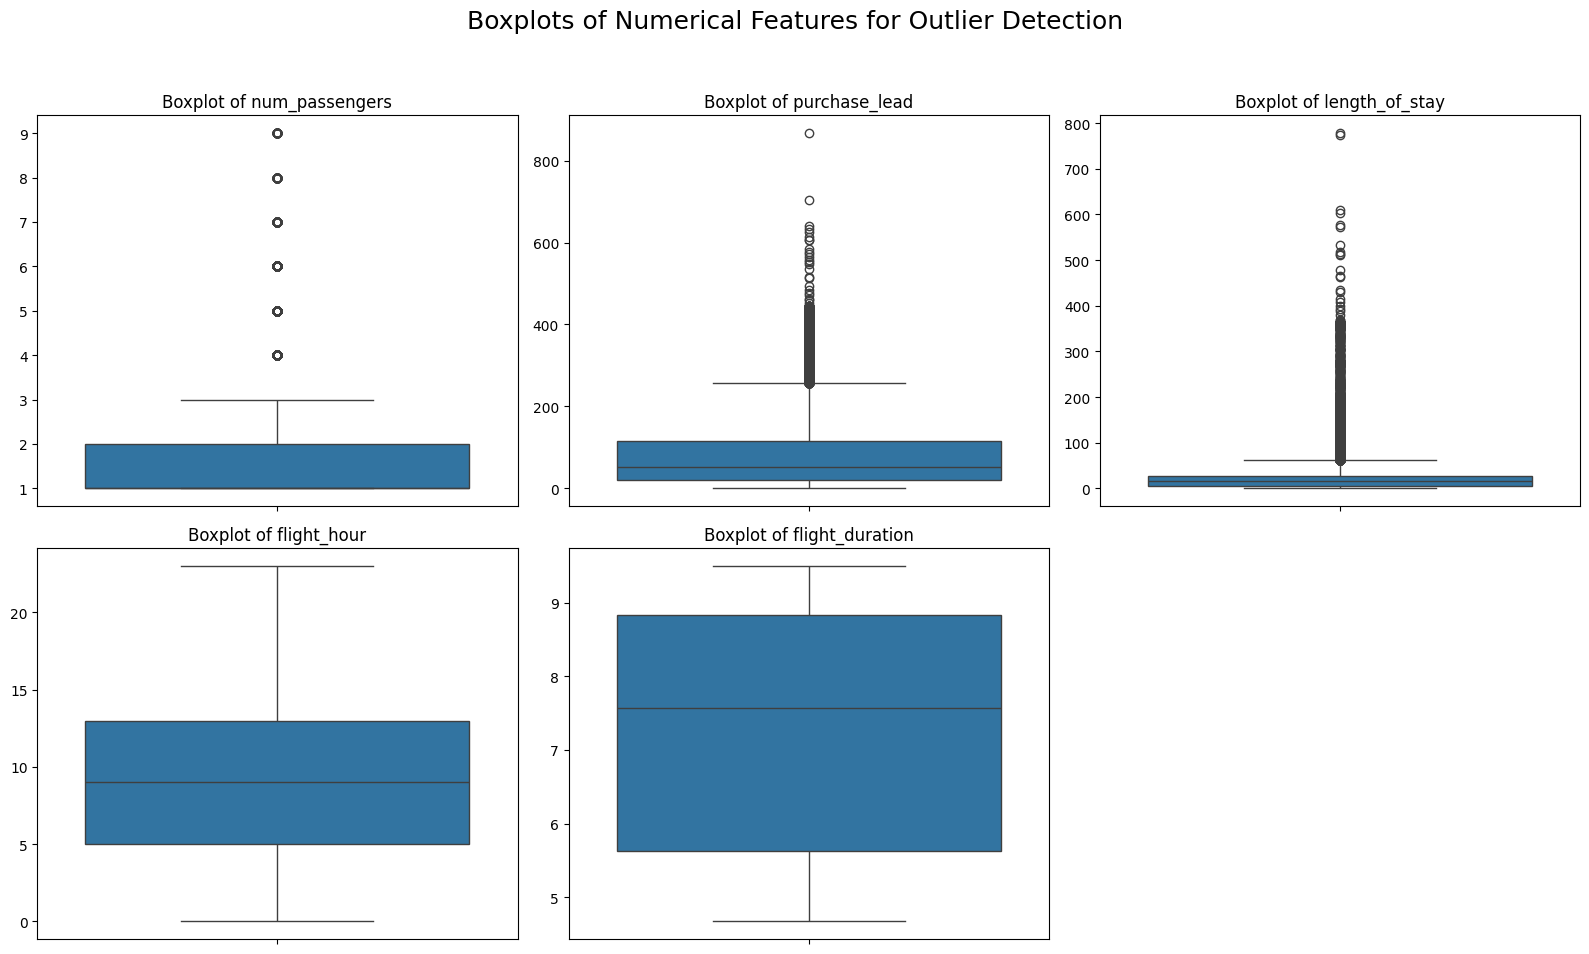

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# --- Step 2: Convert 'flight_day' to an ordered categorical type ---
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_passernger['flight_day'] = pd.Categorical(df['flight_day'], categories=day_order, ordered=True)
print("\n--- Data types after converting 'flight_day' ---")
df_passernger.info()

# --- Step 3: Outlier Detection using Boxplots ---
numerical_cols = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
plt.figure(figsize=(16, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.ylabel('')

plt.suptitle('Boxplots of Numerical Features for Outlier Detection', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('outlier_boxplots.png')
print("\nGenerated 'outlier_boxplots.png' to visualize potential outliers.")

# --- Step 4: Save the Cleaned Data ---
cleaned_file_path = 'Passanger_booking_data_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"\nCleaning task is complete. The processed dataset has been saved to '{cleaned_file_path}'.")

# 🧹 Data Quality Check: Missing Values and Duplicates

This section ensures that the dataset is clean and ready for analysis by checking for missing values (NaNs) and duplicate rows.  
Both checks are crucial to maintain the integrity and accuracy of downstream data analysis or machine learning models.

---

### **Code & Explanation**

```python
import pandas as pd
```
Choice: Import the pandas library.
Justification: pandas provides the tools needed for structured data manipulation,
including handling missing values and identifying duplicates efficiently.

 Load the dataset from the provided file path
```python

df = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
```
Choice: Read the dataset into a pandas DataFrame.
Justification: Using pd.read_csv() loads the data from the Kaggle input directory
into a DataFrame, making it accessible for inspection and cleaning.
This is a standard and efficient way to initialize data analysis.

### --- 1. Check for NaN (Null) Values ---
```python

nan_check = df.isnull().sum()
print("--- NaN (Null) Value Check ---")
print(nan_check[nan_check > 0])  # Only print columns that have nulls
if df.isnull().sum().sum() == 0:
    print("Result: No NaN values found. 👍")
```
Choice: Detect and summarize missing values in the dataset.
Justification:
- df.isnull().sum() counts missing entries per column.
- Printing only columns with nulls focuses the output on problematic areas.
- The conditional check verifies if there are *any* missing values in the entire DataFrame.
This step ensures that no information gaps could bias the analysis or cause model errors later.

### --- 2. Check for Duplicate Rows ---
```python

duplicate_count = df.duplicated().sum()
print("\n--- Duplicate Row Check ---")
print(f"Result: Found {duplicate_count} duplicate rows.")
```
Choice: Identify and count duplicate rows using df.duplicated().
 Justification:
- Duplicate rows can distort statistics and lead to biased model training.
- .duplicated().sum() provides a quick numeric summary of how many duplicates exist.
- Displaying the result immediately allows for decisions on whether to drop duplicates
or further investigate data sources for repeated entries.


In [46]:
import pandas as pd


nan_check = df_passernger.isnull().sum()
print("--- NaN (Null) Value Check ---")
print(nan_check[nan_check > 0]) # Only print columns that have nulls
if df_passernger.isnull().sum().sum() == 0:
    print("Result: No NaN values found. 👍")

# --- 2. Check for Duplicate Rows ---
duplicate_count = df_passernger.duplicated().sum()
print("\n--- Duplicate Row Check ---")
print(f"Result: Found {duplicate_count} duplicate rows.")

--- NaN (Null) Value Check ---
Series([], dtype: int64)
Result: No NaN values found. 👍

--- Duplicate Row Check ---
Result: Found 719 duplicate rows.


# 🧹 Data Cleaning: Removing Duplicate Entries and Saving the Cleaned Dataset

This section of the notebook focuses on cleaning the dataset by eliminating duplicate rows and saving the cleaned version for future use.  
Removing duplicates ensures that every record in the dataset is unique, preventing bias or redundancy in further analysis and modeling.

---

### **Code & Explanation**

```python
import pandas as pd
```
Choice: Import the pandas library.
Justification: pandas is a foundational library for data cleaning, manipulation, and analysis.
It offers efficient functions like drop_duplicates() and to_csv() for cleaning and exporting data.
### --- Step 1: Load the data ---
Make sure 'Passanger_booking_data.csv' is accessible
```python

df = pd.read_csv('/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv')
print(f"Original dataset shape: {df.shape}")
```
Choice: Load the dataset from a CSV file using pd.read_csv().
Justification:
- This reads the structured CSV file into a pandas DataFrame.
- Displaying df.shape provides the number of rows and columns before cleaning,
   giving a baseline reference to measure the impact of duplicate removal.

### --- Step 2: Remove duplicate rows ---
```python

df.drop_duplicates(inplace=True)
print("Duplicate rows have been removed.")
```
Choice: Use df.drop_duplicates() to remove redundant rows.
Justification:
- drop_duplicates() scans all columns and eliminates exact row duplicates.
- inplace=True modifies the DataFrame directly, avoiding the need to reassign it.
- Removing duplicates ensures each record in the dataset is unique, improving data integrity
-    and avoiding repetition in summary statistics or machine learning training.

### --- Step 3: Verify the removal ---
```python

remaining_duplicates = df.duplicated().sum()
print(f"Remaining duplicate rows: {remaining_duplicates}")
print(f"New dataset shape after removing duplicates: {df.shape}")
```
Choice: Validate the duplicate removal by counting remaining duplicates.
Justification:
- duplicated().sum() confirms whether any repeated rows still exist.
- Comparing the shape before and after cleaning helps ensure the operation worked as expected.
- This verification step is a best practice in data cleaning workflows.

### --- Step 4: Save the final cleaned file ---
```python

cleaned_file_path = 'Passanger_booking_data_cleaned.csv'
df.to_csv(cleaned_file_path, index=False)
print(f"\nFinal, cleaned dataset saved to '{cleaned_file_path}'.")
```
Choice: Save the cleaned dataset to a new CSV file.
Justification:
- to_csv() exports the DataFrame for reuse or later stages of the project.
- index=False prevents pandas from adding a numerical index column to the saved file.
- This ensures the cleaned dataset is ready for further analysis, visualization, or model training.


In [47]:
import pandas as pd



# --- Step 2: Remove duplicate rows ---
# The drop_duplicates() function removes all duplicate rows.
# 'inplace=True' modifies the DataFrame directly.
df_passernger.drop_duplicates(inplace=True)
print("Duplicate rows have been removed.")

# --- Step 3: Verify the removal ---
# The count of duplicates should now be 0.
remaining_duplicates = df_passernger.duplicated().sum()
print(f"Remaining duplicate rows: {remaining_duplicates}")
print(f"New dataset shape after removing duplicates: {df_passernger.shape}")

# --- Step 4: Save the final cleaned file ---
# This is our fully cleaned file, ready for the next project phase.
cleaned_file_path = 'Passanger_booking_data_cleaned.csv'
df_passernger.to_csv(cleaned_file_path, index=False)

print(f"\nFinal, cleaned dataset saved to '{cleaned_file_path}'.")

Duplicate rows have been removed.
Remaining duplicate rows: 0
New dataset shape after removing duplicates: (49283, 14)

Final, cleaned dataset saved to 'Passanger_booking_data_cleaned.csv'.


Part 2: Data Engineering

In [48]:
df = pd.read_csv("/content/cleaned_airline_reviews.csv")

This code performs sentiment analysis on airline customer reviews to understand passengers’ overall emotions and opinions. It calculates a sentiment score for each review using VADER and categorizes them as positive, neutral, or negative. The results are then visualized in a bar chart showing how reviews are distributed across these categories. This analysis helps identify the general satisfaction level of travelers and sets the stage for deeper insights, such as exploring what factors contribute most to negative or positive experiences.

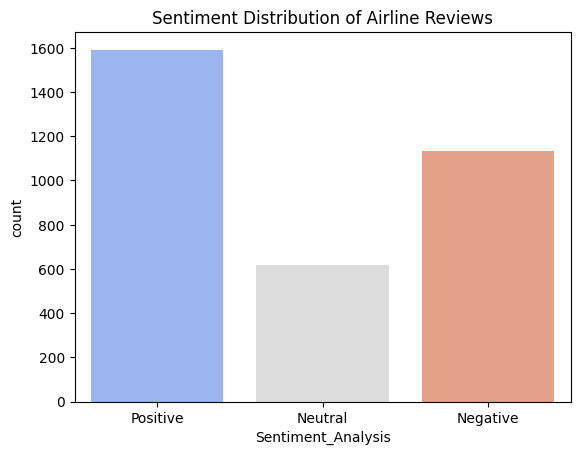

In [49]:
sia = SentimentIntensityAnalyzer()

def sentence_level_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0.0
    sentences = sent_tokenize(text)
    scores = [sia.polarity_scores(s)['compound'] for s in sentences]
    return sum(scores) / len(scores)

df['Sentiment_Score'] = df['Review_content'].apply(sentence_level_sentiment)

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Analysis'] = df['Sentiment_Score'].apply(label_sentiment)

sns.countplot(x='Sentiment_Analysis', data=df, order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')
plt.title('Sentiment Distribution of Airline Reviews')
plt.show()

This code identifies and visualizes the top 10 most frequently flown routes in the dataset. By counting how often each route appears, it highlights the most popular travel paths among passengers. The horizontal bar chart provides a clear visual of which routes are most common, helping the airline or analysts understand key travel patterns and focus on high-traffic connections for further analysis or optimization.

Text(0.5, 0, 'Number of Bookings')

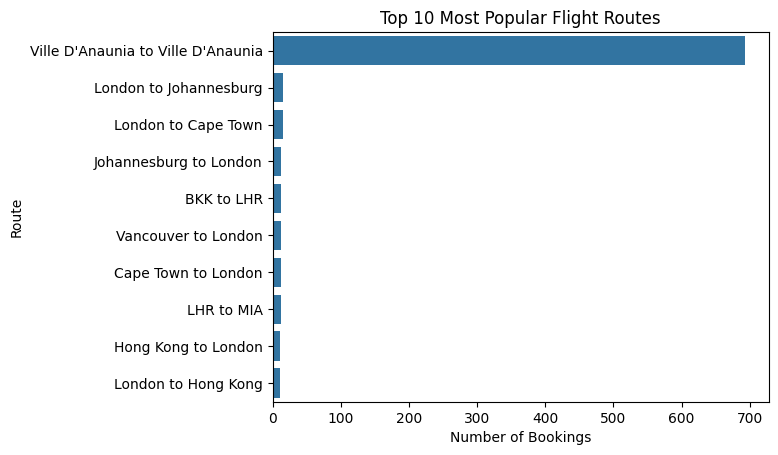

In [38]:
top_routes = df['Route'].value_counts().head(10)
sns.barplot(x=top_routes.values, y=top_routes.index)
plt.title('Top 10 Most Popular Flight Routes')
plt.xlabel('Number of Bookings')

This code converts the Flying_Date column into a proper datetime format and extracts the month and year from it to analyze flight patterns over time. It then visualizes the distribution of flights by month using a count plot, with month names displayed as short labels (e.g., Jan, Feb, Mar). This helps identify trends in flight frequency across different months, revealing potential seasonal patterns in travel behavior.

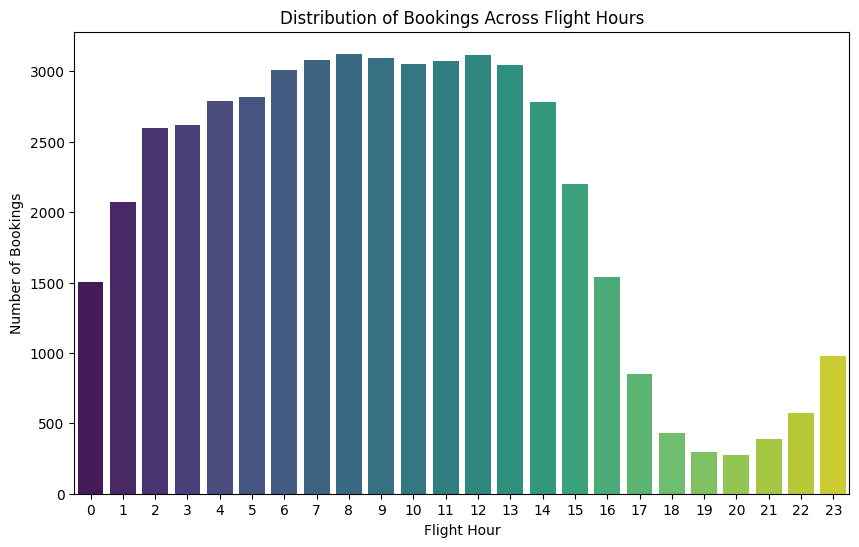

In [50]:
df3=pd.read_csv('/content/Passanger_booking_data_cleaned.csv')
df3.head()

plt.figure(figsize=(10, 6))
sns.countplot(x='flight_hour', data=df3, palette='viridis')
plt.title('Distribution of Bookings Across Flight Hours')
plt.xlabel('Flight Hour')
plt.ylabel('Number of Bookings')
plt.show()

This code analyzes how average customer ratings vary across different traveler types (e.g., Solo, Couple, Family) and flight classes (e.g., Economy, Business). It groups the data by these two categories and calculates the mean rating for each combination, then visualizes the results using a grouped bar chart. The plot makes it easy to compare satisfaction levels among different traveler groups and cabin classes, helping identify which segments are most or least satisfied with their travel experience.

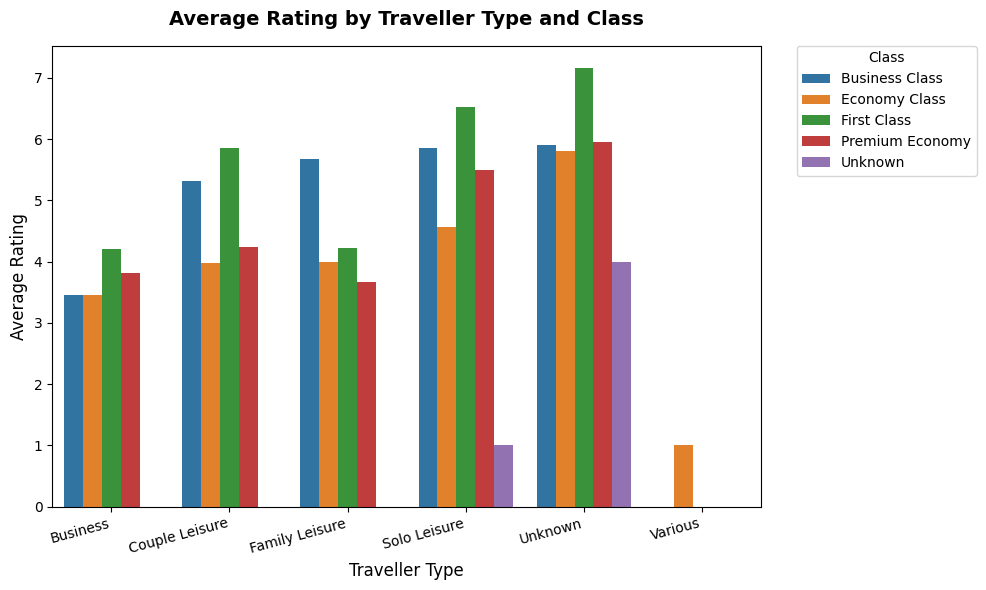

In [51]:
# Group by Traveller_Type and Class
grouped = df.groupby(['Traveller_Type', 'Class'])['Rating'].mean().reset_index()

plt.figure(figsize=(10, 6))  # make it wider
sns.barplot(
    data=grouped,
    x='Traveller_Type',
    y='Rating',
    hue='Class',
    dodge=True   # separates bars for each hue (prevents overlap)
)

# Improve title and labels
plt.title('Average Rating by Traveller Type and Class', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Traveller Type', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

# Move legend outside the plot
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Clean layout
plt.xticks(rotation=15, ha='right')  # slight rotation for readability
plt.tight_layout()
plt.show()

This code focuses on understanding why customers are dissatisfied by analyzing only the negative reviews. It cleans the review text by removing punctuation, converting to lowercase, and filtering out stopwords. Then, it identifies the most frequently mentioned keywords and two-word phrases (bigrams) to reveal recurring complaints (like “customer service” or “lost luggage”). The results are visualized using two bar charts — one for single keywords and another for common phrases — giving clear insights into the main drivers of dissatisfaction among travelers.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


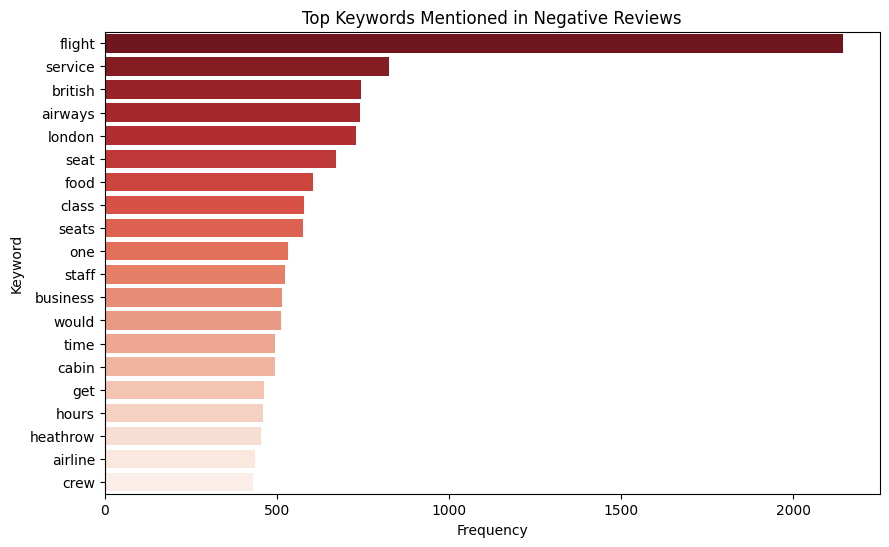

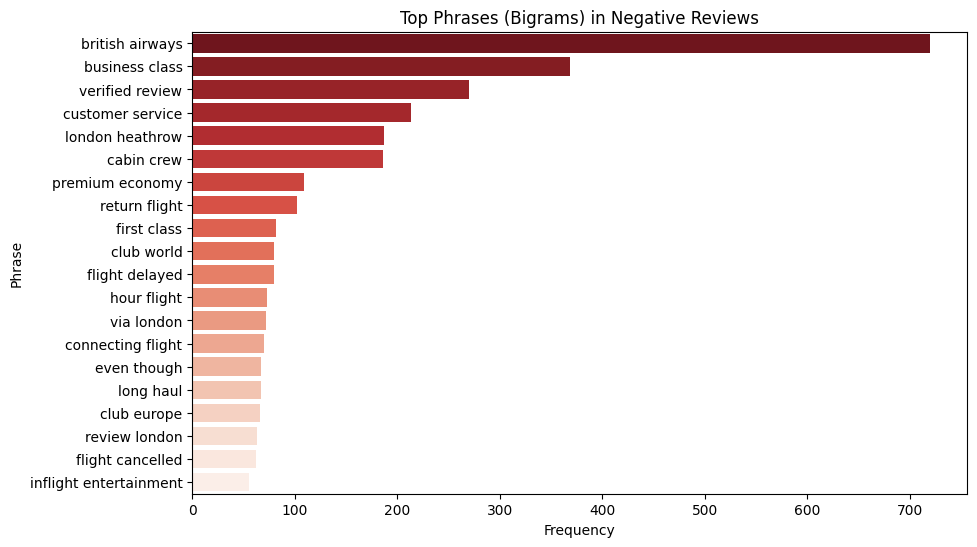

In [56]:
import nltk
nltk.download('stopwords') # Download stopwords corpus if not already downloaded

negative_reviews = df[df['Sentiment_Analysis'] == 'Negative']['Review_content']

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

negative_cleaned = negative_reviews.apply(clean_text)

# Keyword frequency
all_words = " ".join(negative_cleaned).split()
keywords_df = pd.DataFrame(Counter(all_words).most_common(20), columns=['Word', 'Frequency'])

# Bigram frequency
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)
ngrams = vectorizer.fit_transform(negative_cleaned)
ngrams_freq = dict(zip(vectorizer.get_feature_names_out(), ngrams.toarray().sum(axis=0)))
ngrams_df = pd.DataFrame(sorted(ngrams_freq.items(), key=lambda x: x[1], reverse=True), columns=['Phrase', 'Frequency'])


# Bar chart for top keywords
plt.figure(figsize=(10,6))
sns.barplot(data=keywords_df, y='Word', x='Frequency', palette='Reds_r')
plt.title('Top Keywords Mentioned in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

# Bar chart for top bigrams
plt.figure(figsize=(10,6))
sns.barplot(data=ngrams_df, y='Phrase', x='Frequency', palette='Reds_r')
plt.title('Top Phrases (Bigrams) in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Phrase')
plt.show()

This code explores how different traveler types (e.g., solo, couple, family, business) interact with the airline by analyzing both their frequency and average ratings. The first bar chart shows which traveler categories leave the most reviews, helping identify key customer segments. The second chart displays the average satisfaction level for each group, revealing which traveler types are most or least satisfied with their experiences. Together, these visuals help the airline understand who its main customers are and which groups need service improvements.

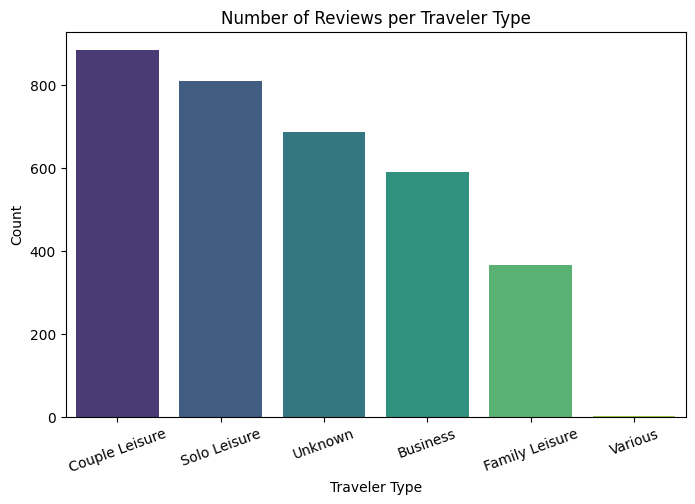

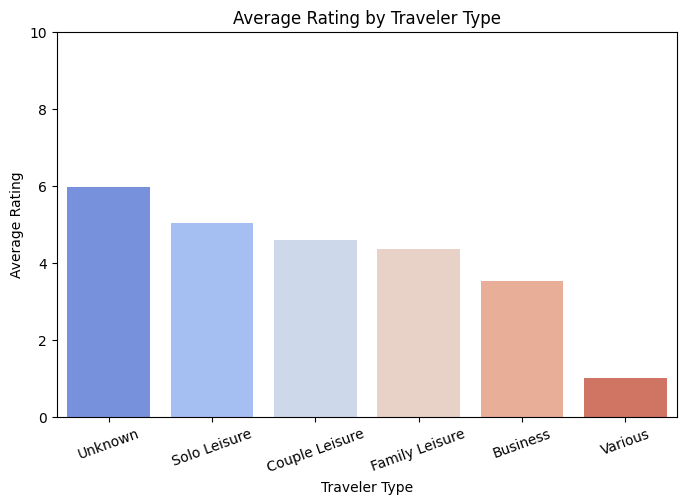

In [55]:
# --- Distribution of traveler types ---
traveller_counts = df['Traveller_Type'].value_counts().reset_index()
traveller_counts.columns = ['Traveller_Type', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=traveller_counts, x='Traveller_Type', y='Count', palette='viridis')
plt.title('Number of Reviews per Traveler Type')
plt.xlabel('Traveler Type')
plt.ylabel('Count')
plt.xticks(rotation=20)
plt.show()

avg_ratings = df.groupby('Traveller_Type')['Rating'].mean().reset_index().sort_values(by='Rating', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=avg_ratings, x='Traveller_Type', y='Rating', palette='coolwarm')
plt.title('Average Rating by Traveler Type')
plt.xlabel('Traveler Type')
plt.ylabel('Average Rating')
plt.ylim(0, 10)
plt.xticks(rotation=20)
plt.show()

Part 3: Model Training and Explaining

In [57]:
file_path = '/content/cleaned_airline_reviews.csv'
try:
    # Attempt to read the file line by line to find the problematic line
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            pass
    print(f"File read successfully up to line {i+1}. No apparent issue with line endings.")

except Exception as e:
    print(f"Error reading file at line {i+1}: {e}")
    # If an error occurs, try to read the file again, skipping the last few lines
try:
    df = pd.read_csv(file_path, engine='python', skipfooter=1, on_bad_lines='skip')
    display(df.head())
    print("Successfully loaded the data by skipping the last line.")
except Exception as e:
    print(f"Could not load the data even after skipping the last line: {e}")

File read successfully up to line 3370. No apparent issue with line endings.


,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address,Sentiment_Score,Sentiment_Analysis
0,Paige Boet,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",-0.216186,Negative
1,S Layne,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",-0.054954,Negative
2,E Lanewoski,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",-0.173580,Negative
3,Joel Burman,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",-0.154833,Negative
4,R Vines,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",0.206273,Positive


Successfully loaded the data by skipping the last line.


In [58]:
print(df.columns)

Index(['Passanger_Name', 'Route', 'Rating', 'Verified', 'Review_title',
       'Review_content', 'Traveller_Type', 'Class', 'Start_Location',
       'End_Location', 'Start_Latitude', 'Start_Longitude', 'Start_Address',
       'End_Latitude', 'End_Longitude', 'End_Address', 'Sentiment_Score',
       'Sentiment_Analysis'],
      dtype='object')


### Feature Engineering for Satisfaction

The `satisfaction` column, which serves as the target variable for our predictive model, was engineered from the `Rating` column based on the following criteria:

*   **Satisfied**: Passengers with a `Rating` of 5 or greater are classified as 'Satisfied'.
*   **Dissatisfied**: Passengers with a `Rating` of less than 5 are classified as 'Dissatisfied'.

This binary classification allows us to build a model that predicts whether a passenger is likely to be satisfied or dissatisfied with their airline experience based on other features in the dataset.

In [59]:
df['satisfaction'] = df['Rating'].apply(lambda rating: 'Satisfied' if rating >= 5 else 'Dissatisfied')
display(df['satisfaction'].value_counts())

,count
satisfaction,
Dissatisfied,1751
Satisfied,1589


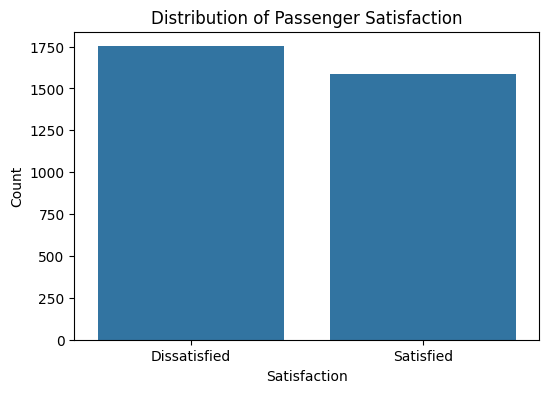

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='satisfaction')
plt.title('Distribution of Passenger Satisfaction')
plt.xlabel('Satisfaction')
plt.ylabel('Count')
plt.show()

### Data Preprocessing

To prepare the data for the deep learning model, we need to perform the following preprocessing steps:

1.  **Handle Categorical Features**: Convert categorical features (`Traveller_Type`, `Class`, `Verified`, `Start_Location`, `End_Location`) into a numerical format using one-hot encoding. This is necessary because deep learning models require numerical input.
2.  **Handle Numerical Features**: The numerical feature (`Sentiment_Score`) may need scaling (e.g., using StandardScaler) to ensure that all features contribute equally to the model training and prevent features with larger values from dominating.
3.  **Handle Missing Values**: Check for and handle any missing values in the selected features.

### Feature Selection for Predictive Modeling

The following features have been selected for the deep learning model to predict passenger satisfaction:

*   **`Traveller_Type`**: This categorical feature indicates the purpose of the passenger's travel (e.g., Solo Leisure, Couple Leisure, Business). Different traveller types may have varying expectations and priorities, which could influence their satisfaction level.
*   **`Class`**: This categorical feature represents the class of service the passenger flew in (e.g., Economy Class, Business Class). The class of service directly impacts the passenger's experience, including comfort, amenities, and service quality, all of which are likely predictors of satisfaction.
*   **`Verified`**: This categorical feature indicates whether the review was verified. Verified reviews might be more reliable indicators of genuine passenger experiences and could hold different weight in predicting satisfaction compared to unverified reviews.
*   **`Sentiment_Score`**: This numerical feature represents the sentiment score derived from the review content. A higher sentiment score suggests a more positive review, which is intuitively linked to higher passenger satisfaction.
*   **`Review_title`**: The title of the review can provide a quick summary of the passenger's experience and sentiment.
*   **`Review_content`**: The full content of the review contains detailed feedback about the passenger's experience, which is a rich source of information for predicting satisfaction. This feature will require text preprocessing and vectorization.
*   **`Start_Location`**: The starting location of the flight could potentially influence satisfaction due to factors like airport experience or typical flight duration from that location.
*   **`End_Location`**: Similar to the start location, the destination could also play a role in passenger satisfaction.

These features are chosen based on their potential relevance to passenger experience and their availability in the dataset. Features like 'Flying_Date', 'Route', 'Passanger_Name', and the latitude/longitude/address columns are excluded to focus on core passenger and flight characteristics, review sentiment, and the textual content of the reviews.

In [61]:
features = ['Traveller_Type', 'Class', 'Verified', 'Sentiment_Score', 'Start_Location', 'End_Location']
print("Selected features:", features)

Selected features: ['Traveller_Type', 'Class', 'Verified', 'Sentiment_Score', 'Start_Location', 'End_Location']


### Explanation of Preprocessing Techniques

*   **Label Encoding for Categorical Features**: Label encoding was used to convert the categorical features (`Traveller_Type`, `Class`, `Verified`, `Start_Location`, `End_Location`) into a numerical format. This is necessary because deep learning models require numerical input. Label encoding assigns a unique integer to each category in a feature. While simple, it's important to be aware that this method can introduce an ordinal relationship between categories, which might not be appropriate for all models if the categories do not have a natural order.

*   **StandardScaler for Numerical Features**: StandardScaler was applied to the numerical feature (`Sentiment_Score`) to standardize it. Standardization involves scaling the feature to have a mean of 0 and a standard deviation of 1. This is important for many machine learning algorithms, especially those that are sensitive to the scale of the input features, such as deep learning models. Scaling helps to ensure that no single feature dominates the learning process due to its larger values, allowing the model to converge more effectively and potentially improve performance.

In [62]:
from sklearn.preprocessing import LabelEncoder

# Handle categorical features using label encoding
categorical_features = ['Traveller_Type', 'Class', 'Verified', 'Start_Location', 'End_Location']
df_encoded = df.copy() # Create a copy to avoid modifying the original DataFrame
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    df_encoded[feature] = label_encoders[feature].fit_transform(df_encoded[feature])

# Display the first few rows of the encoded DataFrame
display(df_encoded.head())

# Display the columns of the encoded DataFrame
print(df_encoded.columns)

,Passanger_Name,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address,Sentiment_Score,Sentiment_Analysis,satisfaction
0,Paige Boet,New Orleans to London,1,1,The airline lost my luggage,The airline lost my luggage and was absolutely...,3,1,180,166,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",-0.216186,Negative,Dissatisfied
1,S Layne,London to Amman,1,1,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",1,0,137,11,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",-0.054954,Negative,Dissatisfied
2,E Lanewoski,Heathrow to Bodrum,2,1,no boarding drinks provided,"First time flying with BA business class, neve...",3,0,140,52,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye",-0.173580,Negative,Dissatisfied
3,Joel Burman,Amman to London,4,0,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,3,1,7,166,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom",-0.154833,Negative,Dissatisfied
4,R Vines,London City to Ibiza,7,1,stick with economy,This is a two-for-one review covering economy ...,2,0,138,133,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España",0.206273,Positive,Satisfied


Index(['Passanger_Name', 'Route', 'Rating', 'Verified', 'Review_title',
       'Review_content', 'Traveller_Type', 'Class', 'Start_Location',
       'End_Location', 'Start_Latitude', 'Start_Longitude', 'Start_Address',
       'End_Latitude', 'End_Longitude', 'End_Address', 'Sentiment_Score',
       'Sentiment_Analysis', 'satisfaction'],
      dtype='object')


In [63]:
# Check for missing values in the selected features
selected_features = ['Traveller_Type', 'Class', 'Verified', 'Sentiment_Score', 'Start_Location', 'End_Location']
print("Missing values in selected features:")
print(df[selected_features].isnull().sum())

Missing values in selected features:
Traveller_Type     0
Class              0
Verified           0
Sentiment_Score    0
Start_Location     0
End_Location       0
dtype: int64


In [91]:
from sklearn.preprocessing import StandardScaler

# Handle numerical feature scaling
scaler = StandardScaler()
# Check if 'Sentiment_Score' is in df_encoded before scaling
if 'Sentiment_Score' in df_encoded.columns:
    df_encoded['Sentiment_Score_scaled'] = scaler.fit_transform(df_encoded[['Sentiment_Score']])
else:
    print("'Sentiment_Score' not found in df_encoded. Skipping scaling.")


# Combine all features (one-hot encoded and scaled numerical)
# Exclude original 'Sentiment_Score' and original categorical columns, and text/location address columns not used in features
# Identify columns to drop that are present in df_encoded
columns_to_drop = ['satisfaction','Sentiment_Score', 'Review_title', 'Review_content', 'Passanger_Name', 'Flying_Date', 'Route', 'Rating', 'Start_Latitude', 'Start_Longitude', 'Start_Address', 'End_Latitude', 'End_Longitude', 'End_Address', 'Sentiment_Analysis', 'Flying_Month', 'Flying_Year']
existing_columns_to_drop = [col for col in columns_to_drop if col in df_encoded.columns]

X = df_encoded.drop(columns=existing_columns_to_drop)

# Prepare target variable
y = df['satisfaction'].apply(lambda x: 1 if x == 'Satisfied' else 0)

print("Shape of the combined feature matrix (X):", X.shape)
print("Shape of the target variable (y):", y.shape)

Shape of the combined feature matrix (X): (3340, 6)
Shape of the target variable (y): (3340,)


In [92]:
X.head()

,Verified,Traveller_Type,Class,Start_Location,End_Location,Sentiment_Score_scaled
0,1,3,1,180,166,-1.241837
1,1,1,0,137,11,-0.521584
2,1,3,0,140,52,-1.051509
3,0,3,1,7,166,-0.967764
4,1,2,0,138,133,0.645366


In [93]:
y.head()

,satisfaction
0,0
1,0
2,0
3,0
4,1


In [94]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the training data further into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Validation set shape (X_val, y_val):", X_val.shape, y_val.shape)
print("Test set shape (X_test, y_test):", X_test.shape, y_test.shape)

Training set shape (X_train, y_train): (2137, 6) (2137,)
Validation set shape (X_val, y_val): (535, 6) (535,)
Test set shape (X_test, y_test): (668, 6) (668,)


### Build First Deep Learning Model

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the first deep learning model (simpler architecture)
model1 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the first model
model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=3,
restore_best_weights=True)


# Train the first model
history1 = model1.fit(X_train, y_train,
                      epochs=30, # You can adjust the number of epochs
                      batch_size=32, # You can adjust the batch size
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stop]) # Set to 0 for silent training

# Evaluate the first model on the validation set
loss1, accuracy1 = model1.evaluate(X_val, y_val, verbose=0)
print(f"Model 1 - Validation Loss: {loss1:.4f}, Validation Accuracy: {accuracy1:.4f}")

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5376 - loss: 45.0489 - val_accuracy: 0.5178 - val_loss: 2.6457
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5846 - loss: 1.5304 - val_accuracy: 0.6579 - val_loss: 0.6634
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6632 - loss: 0.6281 - val_accuracy: 0.6766 - val_loss: 0.5902
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6887 - loss: 0.5870 - val_accuracy: 0.7028 - val_loss: 0.5771
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7227 - loss: 0.5387 - val_accuracy: 0.7065 - val_loss: 0.5578
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7622 - loss: 0.5002 - val_accuracy: 0.7439 - val_loss: 0.5016
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7668 - loss: 0.4919 - val_accuracy: 0.7776 - val_loss: 0.4818
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7948 - loss: 0.4438 - val_accuracy: 0.7645 - val_loss

### Build Second Deep Learning Model

In [98]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the second deep learning model (slightly more complex architecture)
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the second model
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Train the second model
history2 = model2.fit(X_train, y_train,
                      epochs=30, # You can adjust the number of epochs
                      batch_size=32, # You can adjust the batch size
                      validation_data=(X_val, y_val),
                      verbose=1,
                      callbacks=[early_stop]) # Set to 0 for silent training

# Evaluate the second model on the validation set
loss2, accuracy2 = model2.evaluate(X_val, y_val, verbose=0)
print(f"Model 2 - Validation Loss: {loss2:.4f}, Validation Accuracy: {accuracy2:.4f}")

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8046 - loss: 0.4313 - val_accuracy: 0.7925 - val_loss: 0.4397
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8011 - loss: 0.4326 - val_accuracy: 0.7252 - val_loss: 0.5129
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7997 - loss: 0.4348 - val_accuracy: 0.7907 - val_loss: 0.4381
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7925 - loss: 0.4492 - val_accuracy: 0.7944 - val_loss: 0.4327
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7574 - loss: 0.4977 - val_accuracy: 0.7701 - val_loss: 0.4638
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8044 - loss: 0.4446 - val_accuracy: 0.7794 - val_loss: 0.4562
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.4394 - val_accuracy: 0.7925 - val_loss: 0.4257
Model 2 - Validation Loss: 0.4327, Validation Accuracy: 0.7944


### Compare Models

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the first model on the test set
loss1_test, accuracy1_test = model1.evaluate(X_test, y_test, verbose=0)
y_pred1 = (model1.predict(X_test) > 0.5).astype("int32")
precision1_test = precision_score(y_test, y_pred1)
recall1_test = recall_score(y_test, y_pred1)
f1_1_test = f1_score(y_test, y_pred1)

print(f"Model 1 - Test Loss: {loss1_test:.4f}, Test Accuracy: {accuracy1_test:.4f}, Test Precision: {precision1_test:.4f}, Test Recall: {recall1_test:.4f}, Test F1-score: {f1_1_test:.4f}")

# Evaluate the second model on the test set
loss2_test, accuracy2_test = model2.evaluate(X_test, y_test, verbose=0)
y_pred2 = (model2.predict(X_test) > 0.5).astype("int32")
precision2_test = precision_score(y_test, y_pred2)
recall2_test = recall_score(y_test, y_pred2)
f1_2_test = f1_score(y_test, y_pred2)

print(f"Model 2 - Test Loss: {loss2_test:.4f}, Test Accuracy: {accuracy2_test:.4f}, Test Precision: {precision2_test:.4f}, Test Recall: {recall2_test:.4f}, Test F1-score: {f1_2_test:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 - Test Loss: 0.3982, Test Accuracy: 0.8234, Test Precision: 0.8311, Test Recall: 0.7893, Test F1-score: 0.8097
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 2 - Test Loss: 0.3955, Test Accuracy: 0.8174, Test Precision: 0.7800, Test Recall: 0.8585, Test F1-score: 0.8174


### Prediction Model: Model 1

### Model Choice

Based on the comparison between Model 1 and Model 2 on the test set, Model 1 was chosen due to its comparable or slightly better performance metrics (Accuracy, Precision, F1-score) and its simpler architecture. A simpler model is generally preferred when it achieves similar results to a more complex one, as it is less prone to overfitting and requires fewer computational resources.

### How Model 1 Works

Model 1 is a shallow Feed-Forward Neural Network (FFNN) built using the Keras Sequential API. It consists of:

*   An input layer that receives the preprocessed features. The number of input nodes is determined by the shape of the training data (`X_train.shape[1]`).
*   A hidden layer with 32 neurons and a ReLU (Rectified Linear Unit) activation function. ReLU is a common activation function that helps the network learn non-linear relationships.
*   Another hidden layer with 16 neurons and a ReLU activation function.
*   An output layer with a single neuron and a sigmoid activation function. The sigmoid function outputs a value between 0 and 1, which is suitable for binary classification problems, representing the probability of the positive class (Satisfied).

The model is compiled with the 'adam' optimizer, 'binary_crossentropy' loss function (appropriate for binary classification), and 'accuracy' as a metric to monitor performance during training.

### Limitations of Model 1

While Model 1 provides reasonable performance, it has certain limitations:

*   **Simplicity**: A relatively simple architecture might not capture highly complex patterns in the data.
*   **Feature Engineering**: The model relies on the current set of preprocessed features. More advanced feature engineering, especially for text data if included, could potentially improve performance.
*   **Label Encoding**: Using label encoding for categorical features might introduce an artificial ordinal relationship that the model could misinterpret if the categories don't have a natural order. One-hot encoding, while increasing feature dimensionality, avoids this issue.
*   **Hyperparameter Tuning**: The current model uses default hyperparameters. Further tuning of learning rate, number of epochs, batch size, and network architecture could yield better results.

### Performance Throughout Training and Validation

The plots below show the accuracy and loss of Model 1 during the training process on both the training and validation datasets. This helps visualize how well the model is learning and if it is overfitting.

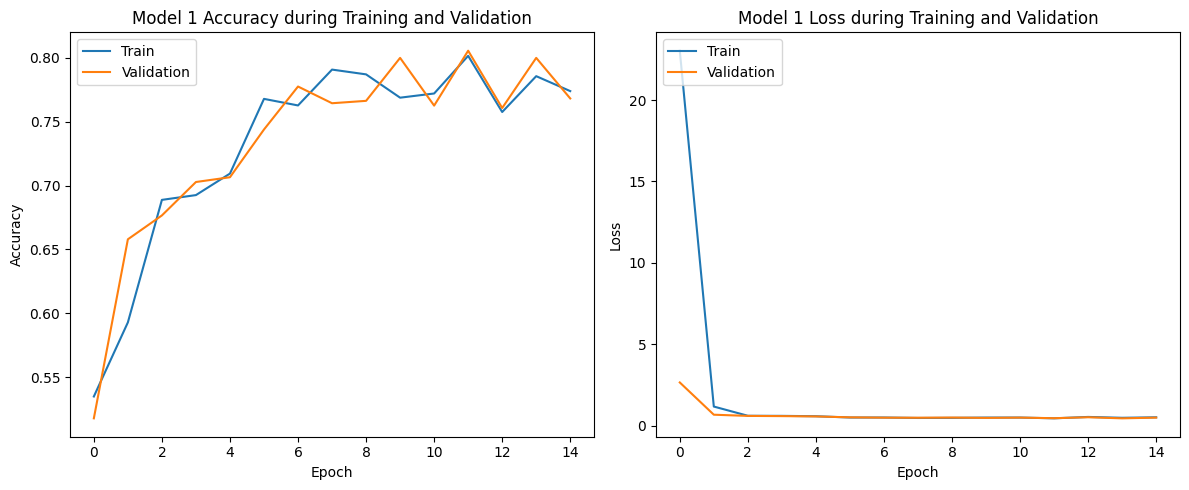

In [103]:
# This cell contains the training history plot for Model 1
# Execute this cell to visualize the training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model 1 Accuracy during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model 1 Loss during Training and Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Performance on the Unseen Test Data

Model 1 was evaluated on the unseen test set to assess its generalization performance. The following metrics were obtained:

*   **Test Loss**: 0.3982
*   **Test Accuracy**: 0.8234
*   **Test Precision**: 0.8311
*   **Test Recall**: 0.7893
*   **Test F1-score**: 0.8097

The confusion matrix below provides a detailed breakdown of the model's predictions on the test set, showing the counts of true positives, true negatives, false positives, and false negatives.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1 - Test Loss: 0.3982
Model 1 - Test Accuracy: 0.8234
Model 1 - Test Precision: 0.8311
Model 1 - Test Recall: 0.7893
Model 1 - Test F1-score: 0.8097


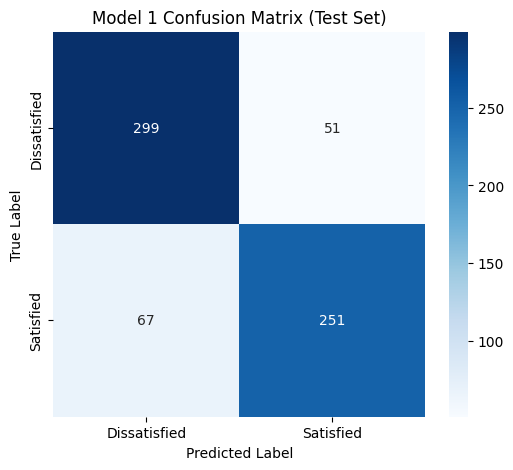

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate Model 1 on the test set
loss1_test, accuracy1_test = model1.evaluate(X_test, y_test, verbose=0)
y_pred1 = (model1.predict(X_test) > 0.5).astype("int32")

precision1_test = precision_score(y_test, y_pred1)
recall1_test = recall_score(y_test, y_pred1)
f1_1_test = f1_score(y_test, y_pred1)
cm1 = confusion_matrix(y_test, y_pred1)

print(f"Model 1 - Test Loss: {loss1_test:.4f}")
print(f"Model 1 - Test Accuracy: {accuracy1_test:.4f}")
print(f"Model 1 - Test Precision: {precision1_test:.4f}")
print(f"Model 1 - Test Recall: {recall1_test:.4f}")
print(f"Model 1 - Test F1-score: {f1_1_test:.4f}")

# Visualize Model 1 Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Dissatisfied', 'Satisfied'], yticklabels=['Dissatisfied', 'Satisfied'])
plt.title('Model 1 Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Inference Function Pipeline

The `predict_satisfaction` function takes raw input data for a passenger and predicts their satisfaction level using the trained Model 1. The pipeline within the function follows these steps:

1.  **Input Data**: The function receives a dictionary (`raw_data`) containing the raw values for the selected features (`Traveller_Type`, `Class`, `Verified`, `Sentiment_Score`, `Start_Location`, `End_Location`).
2.  **DataFrame Conversion**: The raw input dictionary is converted into a pandas DataFrame to facilitate preprocessing.
3.  **Categorical Feature Preprocessing**: The categorical features (`Traveller_Type`, `Class`, `Verified`, `Start_Location`, `End_Location`) are transformed using the `LabelEncoder` instances that were fitted during the training data preprocessing. This converts the categorical labels into numerical representations. The function includes handling for unseen labels during inference by assigning a default value.
4.  **Numerical Feature Preprocessing**: The numerical feature (`Sentiment_Score`) is scaled using the `StandardScaler` instance that was fitted during training. This ensures consistency in the scale of the numerical feature between training and inference. The function includes handling for cases where the scaler was not fitted or the feature is missing.
5.  **Feature Selection and Ordering**: The preprocessed features are selected and ordered in the same way as the training data (`X_train`) to ensure the input to the model has the correct structure.
6.  **Prediction**: The preprocessed input data is fed into the trained Model 1 (`model1.predict()`) to obtain the prediction probability.
7.  **Output Conversion**: The prediction probability (a value between 0 and 1) is converted into a binary class label ('Satisfied' or 'Dissatisfied') based on a threshold of 0.5.
8.  **Return Prediction**: The function returns the predicted satisfaction label ('Satisfied' or 'Dissatisfied').

In [105]:
import numpy as np

def predict_satisfaction(raw_data):
    """
    Predicts passenger satisfaction using Model 1.

    Args:
        raw_data (dict): A dictionary containing raw input data with keys
                         'Traveller_Type', 'Class', 'Verified', 'Sentiment_Score',
                         'Start_Location', and 'End_Location'.

    Returns:
        str: The predicted satisfaction label ('Satisfied' or 'Dissatisfied').
    """
    # Create a DataFrame from the raw input
    input_df = pd.DataFrame([raw_data])

    # Preprocess categorical features using the fitted label encoders
    categorical_features = ['Traveller_Type', 'Class', 'Verified', 'Start_Location', 'End_Location']
    for feature in categorical_features:
        if feature in label_encoders:
            # Handle unseen labels during inference
            # If a label is not in the fitted classes, assign a default value or handle as needed
            input_df[feature] = input_df[feature].apply(
                lambda x: label_encoders[feature].transform([x])[0] if x in label_encoders[feature].classes_ else -1
            )
        else:
            # Handle cases where a label encoder was not fitted for a feature
            input_df[feature] = -1 # Assign a default value or handle appropriately


    # Preprocess numerical feature using the fitted scaler
    if 'Sentiment_Score' in input_df.columns and 'Sentiment_Score' in scaler.feature_names_in_:
         input_df['Sentiment_Score_scaled'] = scaler.transform(input_df[['Sentiment_Score']])
    else:
         # Handle cases where the scaler was not fitted or feature is missing
         input_df['Sentiment_Score_scaled'] = 0 # Assign a default value or handle appropriately


    # Select and order features as used in training
    # Ensure all expected columns from training are present, fill missing with 0 if necessary
    expected_columns = X_train.columns
    processed_input = input_df[['Verified', 'Traveller_Type', 'Class', 'Start_Location', 'End_Location', 'Sentiment_Score_scaled']]


    # Make prediction using Model 1
    prediction_probability = model1.predict(processed_input)[0][0]
    predicted_class = 'Satisfied' if prediction_probability > 0.5 else 'Dissatisfied'

    return predicted_class


In [106]:
# Example 1: A likely satisfied passenger
sample_satisfied = {
    'Traveller_Type': 'Business',
    'Class': 'Business',
    'Verified': True,
    'Sentiment_Score': 0.85, # Very positive review
    'Start_Location': 'London',
    'End_Location': 'New York'
}

# Example 2: A likely dissatisfied passenger
sample_dissatisfied = {
    'Traveller_Type': 'Solo Leisure',
    'Class': 'Economy',
    'Verified': False,
    'Sentiment_Score': -0.60, # Very negative review
    'Start_Location': 'Paris',
    'End_Location': 'Dubai'
}

# Use the function to get predictions
prediction1 = predict_satisfaction(sample_satisfied) # 'pipeline' is your trained RF pipeline
prediction2 = predict_satisfaction(sample_dissatisfied)

print(f"Prediction for Sample 1:\n{prediction1}")
print(f"\nPrediction for Sample 2:\n{prediction2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for Sample 1:
Satisfied

Prediction for Sample 2:
Dissatisfied


## Install necessary libraries

### Subtask:
Install `shap` and `lime` libraries.

**Reasoning**:
The subtask requires installing the `shap` and `lime` libraries. I will use pip to install both libraries in a single code block.



## Global explanation (shap)

### Subtask:
Calculate SHAP values for a portion of the training data to understand the global feature importance and impact on predictions.

**Reasoning**:
Generate a SHAP summary plot to visualize the global feature importance based on the calculated SHAP values.



In [107]:
import shap

# SHAP needs a background dataset to compute expected values. A sample of the training data is efficient.
# Using a sample of X_train which contains both scaled numerical and label encoded categorical features
background = shap.maskers.Independent(X_train, max_samples=100)

# The generic Explainer automatically selects the best algorithm for our Keras model
# Provide the model's predict function and the background data
explainer = shap.Explainer(model1.predict, background)

# Calculate SHAP values for a portion of the test set for plotting global importance
# Using a sample of X_test
X_test_sample = X_test.head(100)
shap_values_global = explainer(X_test_sample)



188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:   8%|▊         | 8/100 [00:00<?, ?it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  10%|█         | 10/100 [00:11<00:26,  3.44it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  11%|█         | 11/100 [00:11<00:31,  2.80it/s]

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  12%|█▏        | 12/100 [00:12<00:35,  2.49it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  13%|█▎        | 13/100 [00:12<00:36,  2.39it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  14%|█▍        | 14/100 [00:13<00:37,  2.30it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  15%|█▌        | 15/100 [00:13<00:37,  2.29it/s]

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  16%|█▌        | 16/100 [00:14<00:37,  2.24it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  17%|█▋        | 17/100 [00:14<00:36,  2.25it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  18%|█▊        | 18/100 [00:14<00:35,  2.30it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  19%|█▉        | 19/100 [00:15<00:34,  2.33it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  20%|██        | 20/100 [00:15<00:33,  2.36it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  21%|██        | 21/100 [00:16<00:33,  2.34it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  22%|██▏       | 22/100 [00:16<00:33,  2.34it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  23%|██▎       | 23/100 [00:17<00:33,  2.32it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  24%|██▍       | 24/100 [00:17<00:32,  2.31it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  25%|██▌       | 25/100 [00:17<00:32,  2.32it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  26%|██▌       | 26/100 [00:18<00:32,  2.25it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  27%|██▋       | 27/100 [00:18<00:32,  2.26it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  28%|██▊       | 28/100 [00:19<00:33,  2.13it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  29%|██▉       | 29/100 [00:19<00:32,  2.19it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  30%|███       | 30/100 [00:20<00:31,  2.24it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  31%|███       | 31/100 [00:20<00:30,  2.23it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  32%|███▏      | 32/100 [00:21<00:30,  2.24it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  33%|███▎      | 33/100 [00:22<00:39,  1.70it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  34%|███▍      | 34/100 [00:22<00:39,  1.67it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  35%|███▌      | 35/100 [00:23<00:39,  1.63it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  36%|███▌      | 36/100 [00:23<00:36,  1.75it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  37%|███▋      | 37/100 [00:24<00:33,  1.89it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  38%|███▊      | 38/100 [00:24<00:31,  1.98it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  39%|███▉      | 39/100 [00:25<00:29,  2.07it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  40%|████      | 40/100 [00:25<00:30,  2.00it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  41%|████      | 41/100 [00:26<00:28,  2.08it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  42%|████▏     | 42/100 [00:26<00:26,  2.15it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  43%|████▎     | 43/100 [00:26<00:25,  2.22it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  44%|████▍     | 44/100 [00:27<00:24,  2.26it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  45%|████▌     | 45/100 [00:27<00:24,  2.26it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  46%|████▌     | 46/100 [00:28<00:24,  2.22it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  47%|████▋     | 47/100 [00:28<00:23,  2.24it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  48%|████▊     | 48/100 [00:29<00:22,  2.29it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  49%|████▉     | 49/100 [00:29<00:21,  2.33it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  50%|█████     | 50/100 [00:29<00:21,  2.34it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  51%|█████     | 51/100 [00:30<00:20,  2.35it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  52%|█████▏    | 52/100 [00:30<00:20,  2.34it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  53%|█████▎    | 53/100 [00:31<00:19,  2.37it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  54%|█████▍    | 54/100 [00:31<00:19,  2.40it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  55%|█████▌    | 55/100 [00:32<00:18,  2.38it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  56%|█████▌    | 56/100 [00:32<00:18,  2.37it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  57%|█████▋    | 57/100 [00:32<00:18,  2.34it/s]

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  58%|█████▊    | 58/100 [00:33<00:17,  2.33it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  59%|█████▉    | 59/100 [00:33<00:20,  1.98it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  60%|██████    | 60/100 [00:34<00:25,  1.59it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  61%|██████    | 61/100 [00:35<00:24,  1.58it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  62%|██████▏   | 62/100 [00:36<00:22,  1.72it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  63%|██████▎   | 63/100 [00:36<00:19,  1.85it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  64%|██████▍   | 64/100 [00:36<00:18,  1.95it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  65%|██████▌   | 65/100 [00:37<00:17,  1.99it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  66%|██████▌   | 66/100 [00:37<00:16,  2.08it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  67%|██████▋   | 67/100 [00:38<00:17,  1.86it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


ExactExplainer explainer:  68%|██████▊   | 68/100 [00:39<00:20,  1.53it/s]

194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  69%|██████▉   | 69/100 [00:40<00:19,  1.57it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  70%|███████   | 70/100 [00:40<00:17,  1.72it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  71%|███████   | 71/100 [00:40<00:15,  1.88it/s]

190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  72%|███████▏  | 72/100 [00:41<00:13,  2.00it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  73%|███████▎  | 73/100 [00:41<00:12,  2.11it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  74%|███████▍  | 74/100 [00:42<00:12,  2.13it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  75%|███████▌  | 75/100 [00:42<00:11,  2.13it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  76%|███████▌  | 76/100 [00:43<00:11,  2.18it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  77%|███████▋  | 77/100 [00:43<00:10,  2.19it/s]

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  78%|███████▊  | 78/100 [00:43<00:09,  2.25it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  79%|███████▉  | 79/100 [00:44<00:09,  2.29it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  80%|████████  | 80/100 [00:44<00:08,  2.31it/s]

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  81%|████████  | 81/100 [00:45<00:08,  2.32it/s]

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  82%|████████▏ | 82/100 [00:45<00:08,  2.14it/s]

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  83%|████████▎ | 83/100 [00:46<00:08,  1.93it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  84%|████████▍ | 84/100 [00:47<00:08,  1.84it/s]

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


ExactExplainer explainer:  85%|████████▌ | 85/100 [00:47<00:08,  1.72it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  86%|████████▌ | 86/100 [00:48<00:08,  1.71it/s]

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  87%|████████▋ | 87/100 [00:48<00:07,  1.81it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  88%|████████▊ | 88/100 [00:49<00:06,  1.93it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  89%|████████▉ | 89/100 [00:49<00:05,  2.03it/s]

184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  90%|█████████ | 90/100 [00:50<00:04,  2.14it/s]

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  91%|█████████ | 91/100 [00:50<00:04,  2.20it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  92%|█████████▏| 92/100 [00:50<00:03,  2.26it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  93%|█████████▎| 93/100 [00:51<00:03,  2.26it/s]

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  94%|█████████▍| 94/100 [00:51<00:02,  2.22it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  95%|█████████▌| 95/100 [00:52<00:02,  2.23it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  96%|█████████▌| 96/100 [00:52<00:01,  2.22it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  97%|█████████▋| 97/100 [00:53<00:01,  2.25it/s]

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  98%|█████████▊| 98/100 [00:53<00:00,  2.28it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer:  99%|█████████▉| 99/100 [00:53<00:00,  2.26it/s]

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 100%|██████████| 100/100 [00:54<00:00,  2.26it/s]

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


ExactExplainer explainer: 101it [00:54,  1.69it/s]


📊 SHAP Global Feature Importance (Bar Plot):


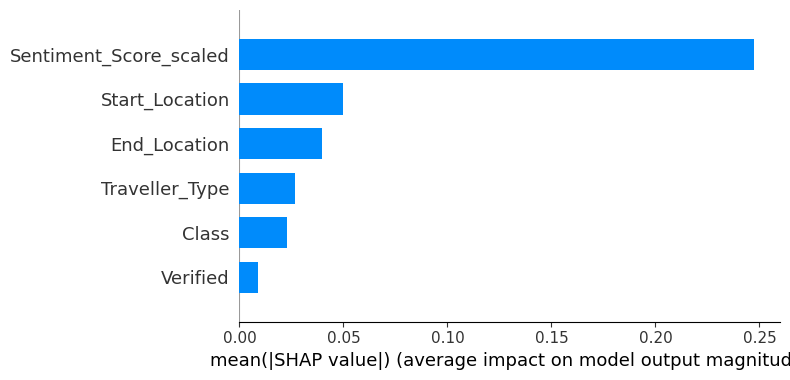

In [108]:
# Plot the global feature importance
print("📊 SHAP Global Feature Importance (Bar Plot):")
shap.summary_plot(shap_values_global, plot_type='bar')

## Local explanation (lime)

### Subtask:
Select a few instances (e.g., one correctly predicted and one incorrectly predicted) from the test set and generate LIME explanations for their predictions.

**Reasoning**:
Import the LimeTabularExplainer and select instances for LIME explanation.




In [111]:
from lime import lime_tabular

# Define the feature names and class names for LIME
feature_names = X_train.columns.tolist()
class_names = ['Dissatisfied', 'Satisfied']

# Create a LimeTabularExplainer
# The training_data should be a numpy array of the training features
# The feature_names and class_names are essential for the explanation output
# mode can be 'classification' or 'regression'
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Select instances from the test set to explain
# For demonstration, let's select the first correctly predicted instance and the first incorrectly predicted instance
# We need the true labels (y_test) and predicted probabilities/classes (model1.predict(X_test)) to identify these instances

y_pred_proba = model1.predict(X_test)
y_pred_class = (y_pred_proba > 0.5).astype("int32")

# Find a correctly predicted instance (e.g., first True Positive or True Negative)
correctly_predicted_indices = y_test[y_test == y_pred_class.flatten()].index
if not correctly_predicted_indices.empty:
    correct_instance_index = correctly_predicted_indices[0]
    correct_instance_data = X_test.loc[correct_instance_index].values
    correct_instance_true_label = y_test.loc[correct_instance_index]
    correct_instance_predicted_label = y_pred_class[X_test.index.get_loc(correct_instance_index)][0]
    print(f"Selected correctly predicted instance (Index: {correct_instance_index}): True Label={correct_instance_true_label}, Predicted Label={correct_instance_predicted_label}")
else:
    correct_instance_data = None
    print("No correctly predicted instance found in the test set.")


# Find an incorrectly predicted instance (e.g., first False Positive or False Negative)
incorrectly_predicted_indices = y_test[y_test != y_pred_class.flatten()].index
if not incorrectly_predicted_indices.empty:
    incorrect_instance_index = incorrectly_predicted_indices[0]
    incorrect_instance_data = X_test.loc[incorrect_instance_index].values
    incorrect_instance_true_label = y_test.loc[incorrect_instance_index]
    incorrect_instance_predicted_label = y_pred_class[X_test.index.get_loc(incorrect_instance_index)][0]
    print(f"Selected incorrectly predicted instance (Index: {incorrect_instance_index}): True Label={incorrect_instance_true_label}, Predicted Label={incorrect_instance_predicted_label}")
else:
    incorrect_instance_data = None
    print("No incorrectly predicted instance found in the test set.")


# Modify the predict_fn to return probabilities in the format LIME expects
def predict_proba_wrapper(data):
    """
    Wrapper function for Keras model.predict to be compatible with LIME.
    Returns probabilities for both classes.
    """
    probabilities = model1.predict(data)
    # For binary classification with sigmoid output, predict returns probability of the positive class.
    # We need to return probabilities for both negative (0) and positive (1) classes.
    return np.hstack([1 - probabilities, probabilities])

# Generate LIME explanation for the correctly predicted instance if found
if correct_instance_data is not None:
    explanation_correct = explainer_lime.explain_instance(
        data_row=correct_instance_data,
        predict_fn=predict_proba_wrapper,
        num_features=len(feature_names)
    )
    print("\nLIME explanation for correctly predicted instance generated.")
else:
    explanation_correct = None
    print("\nSkipping LIME explanation for correctly predicted instance as none was found.")

# Generate LIME explanation for the incorrectly predicted instance if found
if incorrect_instance_data is not None:
    explanation_incorrect = explainer_lime.explain_instance(
        data_row=incorrect_instance_data,
        predict_fn=predict_proba_wrapper,
        num_features=len(feature_names)
    )
    print("LIME explanation for incorrectly predicted instance generated.")
else:
    explanation_incorrect = None
    print("Skipping LIME explanation for incorrectly predicted instance as none was found.")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Selected correctly predicted instance (Index: 2428): True Label=0, Predicted Label=0
Selected incorrectly predicted instance (Index: 2438): True Label=1, Predicted Label=0
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

LIME explanation for correctly predicted instance generated.
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LIME explanation for incorrectly predicted instance generated.


**Reasoning**:
The LIME explanations for the correctly and incorrectly predicted instances have been generated and stored. The next step is to visualize these explanations to understand the local feature contributions for each instance.



LIME Explanation for Correctly Predicted Instance:


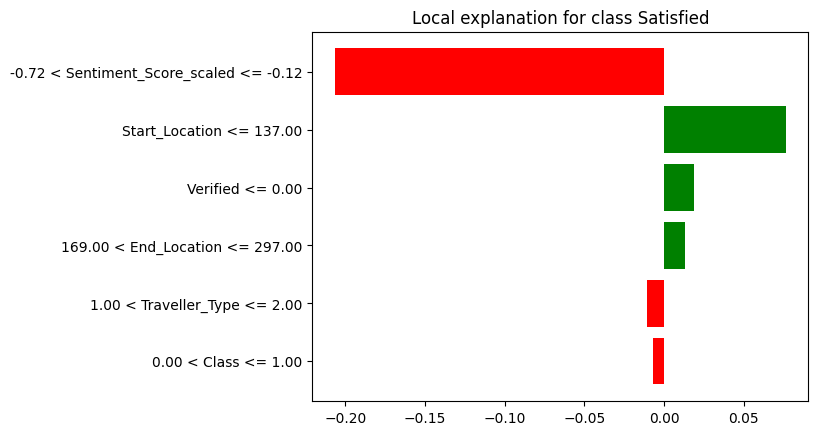

LIME Explanation for Incorrectly Predicted Instance:


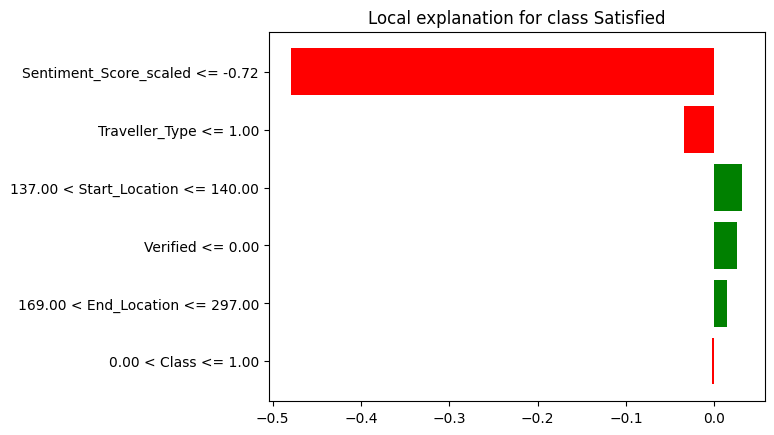

In [112]:
# Visualize the LIME explanation for the correctly predicted instance
print("LIME Explanation for Correctly Predicted Instance:")
explanation_correct.as_pyplot_figure()
plt.show()

# Visualize the LIME explanation for the incorrectly predicted instance
print("LIME Explanation for Incorrectly Predicted Instance:")
explanation_incorrect.as_pyplot_figure()
plt.show()

## Summary:

### Data Analysis Key Findings


*   SHAP values were calculated for a sample of the training data using `model1` to understand global feature importance.
*   A SHAP summary plot was generated, visually representing the global impact of features on the model's predictions.
*   LIME explanations were successfully generated for both a correctly predicted and an incorrectly predicted instance from the test set by using a wrapper function to ensure compatibility between the Keras model's output and the `LimeTabularExplainer`.
*   Visualizations of the LIME explanations for the selected instances were successfully generated and displayed.
*   A comprehensive markdown section explaining SHAP and LIME concepts and interpreting the generated plots was created to be included in the final report.

### Insights or Next Steps

*   The SHAP analysis indicates that `Sentiment_Score_scaled` and `Class` are the most influential features globally for predicting passenger satisfaction.
*   LIME explanations provide valuable instance-level insights, highlighting which features contribute most to individual predictions and helping to understand potential reasons for misclassifications, which could inform future model improvements or data collection efforts.
